# Detection Model Training

### Installation

In [34]:
! pip install torch
! pip install pandas
! pip install matplotlib
! pip install torchaudio
! pip install librosa
! pip install scikit-learn
! pip install torchsummary


[notice] A new release of pip is available: 24.0 -> 24.2
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 24.0 -> 24.2
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 24.0 -> 24.2
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 24.0 -> 24.2
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 24.0 -> 24.2
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 24.0 -> 24.2
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 24.0 -> 24.2
[notice] To update, run: pip install --upgrade pip


### Download the required dataset and labels

In [ ]:
! wget https://ndownloader.figshare.com/files/10853303 -O ff1010bird_metadata_2018.csv
! wget https://archive.org/download/ff1010bird/ff1010bird_wav.zip
! unzip ff1010bird_wav.zip # TODO: split the dataset into 0 and 1

### Imports

In [1]:
import torch
from torch import nn
import torchaudio
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import os
import librosa
import time
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import numpy as np
from IPython.display import Audio
from torch.functional import F
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

### Files and Folders

In [2]:
dataset_folder = "../../dataset-detection" # Change this later
annotation_file = "ff1010bird_metadata_2018.csv"

### Hyperparameters

In [3]:
EPOCHS = 10
BATCH_SIZE = 32
SAMPLE_RATE = 22050
HOP_SIZE = 128
FRAME_SIZE = 512
NUM_CLASSES = 1 # Either Bird Sound is present or Not present
N_MFCC = 13
DURATION = 10 # 10 seconds of each audio clip

In [4]:
device = torch.device("mps")

## Loading the Dataset

In [14]:
class DetectionDataset(Dataset):
    def __init__(self, df, transform=False):
        super().__init__()
        self.df = df
        self.transform = transform
    
    def __len__(self):
        return self.df.shape[0]

    def __getitem__(self, idx):
        label = self.df["hasbird"].iloc[idx]
        itemid = self.df["itemid"].iloc[idx]
        signal, sr = librosa.load(os.path.join(dataset_folder, str(label), str(itemid) + ".wav"))
        
        if sr != SAMPLE_RATE:
            signal = librosa.resample(signal, sr, SAMPLE_RATE)
        
        if self.transform:
            signal = librosa.feature.mfcc(y=signal, sr=SAMPLE_RATE, n_mfcc=N_MFCC, n_fft=FRAME_SIZE, hop_length=HOP_SIZE)
            signal = torch.tensor(signal).unsqueeze(0)
            label = torch.tensor(label,dtype=torch.float32)

        return signal, label

In [15]:
df = pd.read_csv(os.path.join(dataset_folder, annotation_file))
df = df.drop("datasetid",axis=1)
df

,itemid,hasbird
0,64486,0
1,2525,0
2,44981,0
3,101323,0
4,165746,0
...,...,...
7685,168059,0
7686,164922,0
7687,80789,1
7688,104733,1


## Train Test Split

In [26]:
df_train_val, df_test = train_test_split(df, test_size=0.1, shuffle=True, random_state=42)
df_train, df_val = train_test_split(df_train_val,test_size=0.2, shuffle=True, random_state=42)

In [27]:
train_dataset = DetectionDataset(df_train, transform=True)
val_dataset = DetectionDataset(df_val, transform=True)
test_dataset = DetectionDataset(df_test, transform=True)

train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

## Detection Model

In [1]:
class CustomDetectionModel(nn.Module):
    def __init__(self):
        super(CustomDetectionModel, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        
        self._to_linear = None
        self.convs = nn.Sequential(
            self.conv1,
            nn.ReLU(),
            self.pool,
            self.conv2,
            nn.ReLU(),
            self.pool
        )
        self._get_conv_output((1, 1, N_MFCC, 1723))
        
        self.fc1 = nn.Linear(self._to_linear, 128)
        self.fc2 = nn.Linear(128, NUM_CLASSES)
    
    def _get_conv_output(self, shape):
        with torch.no_grad():
            input = torch.rand(shape)
            output = self.convs(input)
            self._to_linear = output.numel()
    
    def forward(self, x):
        x = self.convs(x)
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x


NameError: name 'nn' is not defined

In [29]:
model = CustomDetectionModel().to(device)
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.001)

In [30]:
train_loss_history = []
train_acc_history = []

val_loss_history = []
val_acc_history = []

best_accuracy = 0

for epoch in range(1, EPOCHS + 1):
    model.train()
    train_running_loss = 0.0
    correct_train = 0
    total_train = 0
    
    for signal, label in train_dataloader:
        signal, label = signal.to(device), label.to(device).float()
        optimizer.zero_grad()
        
        pred = model(signal).to(device)
        loss = criterion(pred, label)
        
        loss.backward()
        optimizer.step()

        train_running_loss += loss.item() * signal.size(0)
        predicted = (torch.sigmoid(pred) > 0.5).int()  # Use torch.sigmoid for output probabilities
        total_train += label.size(0)
        correct_train += (predicted == label.int()).sum().item()

    train_loss = train_running_loss / total_train
    train_loss_history.append(train_loss)
    train_accuracy = correct_train / total_train
    train_acc_history.append(train_accuracy)

    model.eval()
    val_running_loss = 0.0
    correct_val = 0
    total_val = 0
    
    with torch.no_grad():
        for data, labels in val_dataloader:
            data, labels = data.to(device), labels.to(device).float()
            outputs = model(data)
            loss = criterion(outputs, labels)
            val_running_loss += loss.item() * data.size(0)
            predicted = (torch.sigmoid(outputs) > 0.5).int()  # Use torch.sigmoid for output probabilities
            total_val += labels.size(0)
            correct_val += (predicted == labels.int()).sum().item()
        
    val_loss = val_running_loss / total_val
    val_loss_history.append(val_loss)
    val_accuracy = correct_val / total_val
    val_acc_history.append(val_accuracy)
    
    if val_accuracy > best_accuracy:
        best_accuracy = val_accuracy
        torch.save(model.state_dict(), "best_model.pth")
    
    print(f'Epoch [{epoch}/{EPOCHS}] ---------------------\n'
          f'Training Loss: {train_loss:.4f}, '
          f'Training Accuracy: {train_accuracy:.4f}\n'
          f'Validation Loss: {val_loss:.4f}, '
          f'Validation Accuracy: {val_accuracy:.4f}\n'
          '---------------------------------------------------------')

Epoch [2/10] ---------------------
Training Loss: 2.1093, Training Accuracy: 0.7453
Validation Loss: 0.5073, Validation Accuracy: 0.7534
---------------------------------------------------------
Epoch [3/10] ---------------------
Training Loss: 0.5001, Training Accuracy: 0.7666
Validation Loss: 0.4722, Validation Accuracy: 0.7773
---------------------------------------------------------
Epoch [4/10] ---------------------
Training Loss: 0.4780, Training Accuracy: 0.7803
Validation Loss: 0.4772, Validation Accuracy: 0.7966
---------------------------------------------------------
Epoch [5/10] ---------------------
Training Loss: 0.4596, Training Accuracy: 0.7883
Validation Loss: 0.4284, Validation Accuracy: 0.7971
---------------------------------------------------------
Epoch [6/10] ---------------------
Training Loss: 0.4441, Training Accuracy: 0.7906
Validation Loss: 0.4063, Validation Accuracy: 0.7939
---------------------------------------------------------
Epoch [7/10] ------------

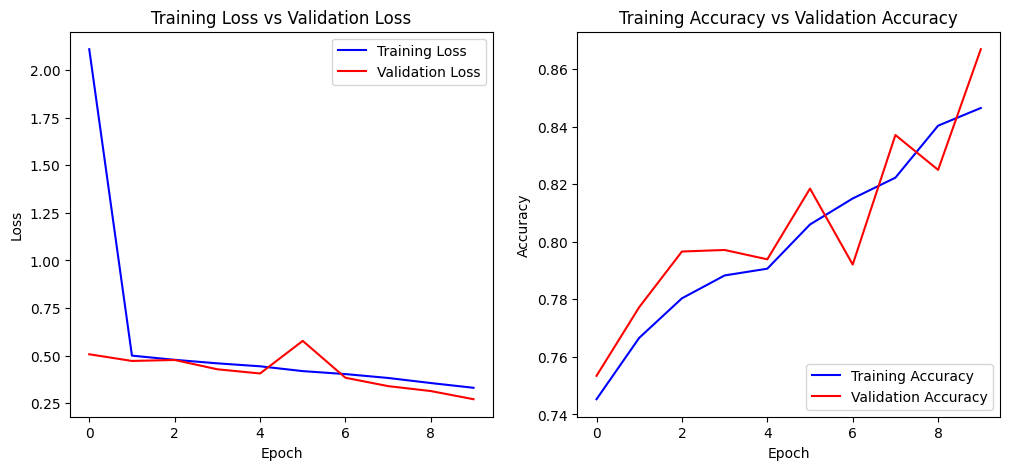

In [32]:
import matplotlib.pyplot as plt

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Plot for training loss vs validation loss
ax1.plot(range(EPOCHS), train_loss_history, color="blue", label='Training Loss')
ax1.plot(range(EPOCHS), val_loss_history, color="red", label='Validation Loss')
ax1.set_title("Training Loss vs Validation Loss")
ax1.set_xlabel("Epoch")
ax1.set_ylabel("Loss")
ax1.legend()

# Plot for training accuracy vs validation accuracy
ax2.plot(range(EPOCHS), train_acc_history, color="blue", label='Training Accuracy')
ax2.plot(range(EPOCHS), val_acc_history, color="red", label='Validation Accuracy')
ax2.set_title("Training Accuracy vs Validation Accuracy")
ax2.set_xlabel("Epoch")
ax2.set_ylabel("Accuracy")
ax2.legend(loc="lower right")

plt.show()

In [31]:
def evaluate(model, dataloader, criterion):
    model.eval()
    val_loss = 0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for signal, label in dataloader:
            signal, label = signal.to(device), label.to(device)
            pred = model(signal).squeeze(1)
            label = torch.tensor(label, dtype=torch.float32)

            loss = criterion(pred, label)
            val_loss += loss.item()

            preds = torch.sigmoid(pred) > 0.5  # Apply sigmoid and threshold at 0.5
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(label.cpu().numpy())

    avg_loss = val_loss / len(dataloader)
    accuracy = accuracy_score(all_labels, all_preds)
    precision = precision_score(all_labels, all_preds)
    recall = recall_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds)

    return avg_loss, accuracy, precision, recall, f1

# Evaluate the model on the validation dataset
val_loss, val_accuracy, val_precision, val_recall, val_f1 = evaluate(model, test_dataloader, criterion)

print(f"Test Loss: {val_loss:.4f}")
print(f"Test Accuracy: {val_accuracy:.4f}")
print(f"Test Precision: {val_precision:.4f}")
print(f"Test Recall: {val_recall:.4f}")
print(f"Test F1 Score: {val_f1:.4f}")

/var/folders/z4/7np1khpd4hv91y__r6wtydmm0000gn/T/ipykernel_17992/1410145472.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label, dtype=torch.float32)


Test Loss: 0.4840
Test Accuracy: 0.7737
Test Precision: 0.6277
Test Recall: 0.2980
Test F1 Score: 0.4041
